In [1]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from langchain.document_loaders import PyPDFLoader
import re
import pandas as pd
import random
import spacy
import nltk
from nltk.tokenize import word_tokenize
import itertools
import networkx as nx
import numpy as np 
import os
import wordcloud
np.random.seed(30224)

In [2]:
os.chdir('/workspaces/UDA_FinalProject_Rempel/')

# Loading DORA and BAIT Documents

In [3]:
def split_dora_by_article(text):
    pattern = r'(?=Article\s\d+\n)'
    parts = re.split(pattern, text)
    for i in range(len(parts)):
        parts[i] = parts[i].split("_____________", 1)[0]
    return parts[1:]
loader = PyPDFLoader('data/dora.pdf')
pages = loader.load_and_split()
#texts starts at page 43

# Main text starts at page 43
pages= pages[43:]
content = ""
for page in pages:
    content += page.page_content
dora=split_dora_by_article(content)
def get_dora_article_header(text):
    return text.split('\n')[0]


df_dora = pd.DataFrame(dora, columns=['text'])
df_dora['title'] = [get_dora_article_header(x) for x in dora]
#print(get_dora_article_header(dora[0]))
#print(dora[0])
df_dora

,text,title
0,Article 1\nSubject matter\n1. In order to achi...,Article 1
1,Article 2\nScope\n1. Without prejudice to para...,Article 2
2,Article 3\nDef initions\nFor the purposes of t...,Article 3
3,Article 4\nPropor tionality principle\n1. Fina...,Article 4
4,Article 5\nGovernance and organisation\n1. Fin...,Article 5
...,...,...
59,Article 60\nAmendments to Regulation (EU) No 6...,Article 60
60,Article 61\nAmendments to Regulation (EU) No 9...,Article 61
61,Article 62\nAmendments to Regulation (EU) No 6...,Article 62
62,Article 63\nAmendment to Regulation (EU) 2016/...,Article 63


In [4]:
def split_bait_by_paragraph(text):
    # Regular expression pattern to match the paragraph headings (X.Y.)
    pattern = r'(?<!\.\d)(?=\b\d+\.\d+\.\s)'
    
    # Remove all occurrances of the word "Circular 10/2017 (BA) in the version of 16.08.2021 Page X of 33" (which is part of the footer)
    tmp = text
    for i in range(1, 34):
        tmp = tmp.replace("Circular 10/2017 (BA) in the version of 16.08.2021 Page " + str(i) + " of 33", "")
    
    # Split the string using the regular expression
    parts = re.split(pattern, tmp)

    # Post-process to remove the last line of the previous part if the current part starts with X.1.
    for i in range(1, len(parts)):
        if parts[i].strip().startswith('1.'):
            parts[i-1] = parts[i-1].rsplit('\n', 1)[0]

    return parts[1:]
loader = PyPDFLoader("data/BAIT_en.pdf")
pages=loader.load_and_split()
content = ""
for page in pages:
    content += page.page_content
bait=split_bait_by_paragraph(content)
def get_bait_article_header(text):
    return text.split(' ')[0]
df_bait = pd.DataFrame(bait, columns=['text'])
df_bait['title'] = [get_bait_article_header(x) for x in bait]
df_bait

,text,title
0,1.1. The IT strategy shall fulfil the requirem...,1.1.
1,1.2. The management board shall define an IT s...,1.2.
2,2.1. IT governance is the structure used to ma...,2.1.
3,2.2. The management board is responsible for e...,2.2.
4,2.3. The institution shall ensure that appropr...,2.3.
...,...,...
82,12.1. Against the backdrop of the other chapte...,12.1.
83,12.2. The extent of critical infrastructure w...,12.2.
84,12.3. The information risk management and info...,12.3.
85,12.4. The CIP objective shall always be taken...,12.4.


In [5]:
pd.set_option('display.max_colwidth', None)
def show_bait_article(title):
    index = df_bait.index[df_bait['title'] == title].tolist()

    print(df_bait['title'][index])
    
    return df_bait['text'].iloc[index]

In [42]:
show_bait_article("2.4.")

5    2.4.
Name: title, dtype: object


5    2.4. Conflicts of interest and activities that are not compatible with each\nother shall be avoided within the organisational and operational\nstructure of IT.Conflicts of interest between activities connected, for example, with applica-\ntion development and tasks performed by IT operations can be countered\nby taking organisation or operational measures and/or by defining roles ad-\nequately.Information risk management\n
Name: text, dtype: object

# Performing some TFIDF-based clustering 

## On each document

2649 ['10' '100' '1011' ... 'ypted' 'yption' 'ys']


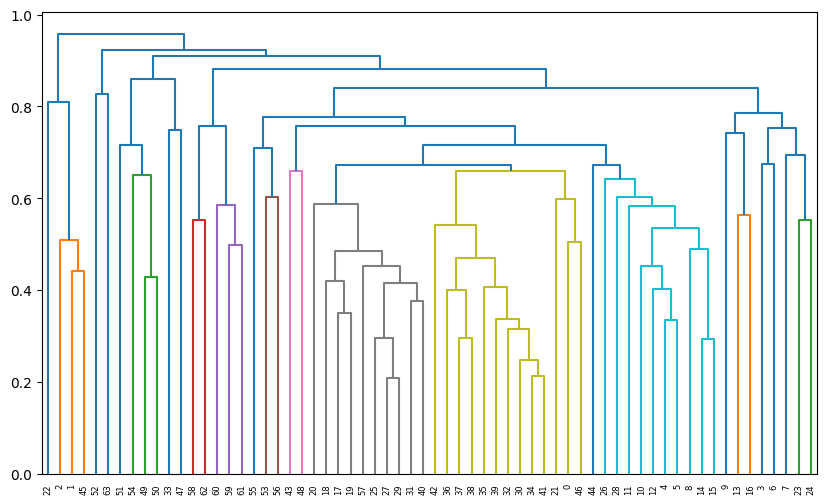

In [39]:
plt.figure(figsize=(10,6))
tfidf = TfidfVectorizer()
text_tfidf = tfidf.fit_transform(df_dora['text'])
feature_names = tfidf.get_feature_names_out()
print(len(feature_names), feature_names)
tree = hac.linkage(text_tfidf.toarray(), method="complete",metric="cosine") #equivalent to 'euclidean'
plt.clf()
hac.dendrogram(tree)#,labels=df_dora['text'])#, labels=df_dora['title']) #, labels=dora_text
plt.show() 

1438 ['10' '11' '12' ... 'zag' 'zur' 'über']


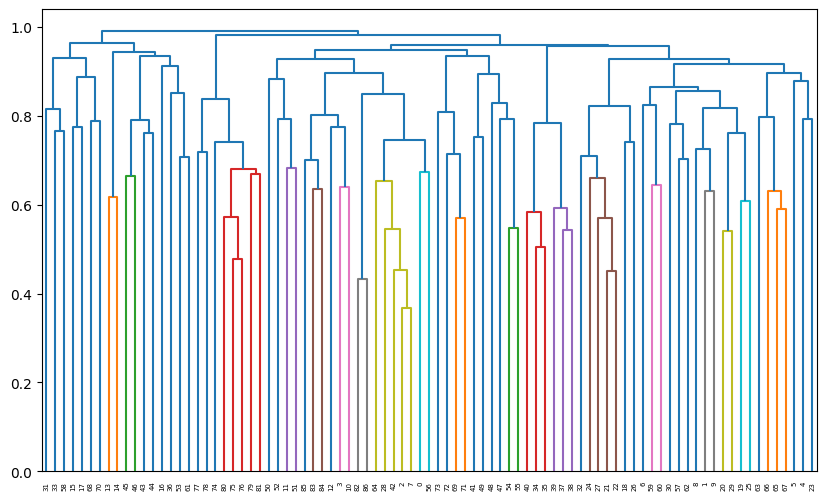

In [40]:
plt.figure(figsize=(10,6))
tfidf_b = TfidfVectorizer()
text_tfidf_b = tfidf_b.fit_transform(df_bait['text'])
feature_names_b = tfidf_b.get_feature_names_out()
print(len(feature_names_b), feature_names_b)
tree_b = hac.linkage(text_tfidf_b.toarray(), method="complete",metric="cosine") #equivalent to 'euclidean'
plt.clf()
hac.dendrogram(tree_b)#,labels=df_dora['text'])#, labels=df_dora['title']) #, labels=dora_text
plt.show() 

## combining both documents

In [7]:
df_comb = pd.concat([df_bait, df_dora], axis=0, keys=['bait', 'dora'])
df_comb = df_comb.reset_index(level=0).rename(columns={'level_0': 'origin'})
df_comb = df_comb.reset_index(drop=True)
df_comb

,origin,text,title
0,bait,1.1. The IT strategy shall fulfil the requirem...,1.1.
1,bait,1.2. The management board shall define an IT s...,1.2.
2,bait,2.1. IT governance is the structure used to ma...,2.1.
3,bait,2.2. The management board is responsible for e...,2.2.
4,bait,2.3. The institution shall ensure that appropr...,2.3.
...,...,...,...
146,dora,Article 60\nAmendments to Regulation (EU) No 6...,Article 60
147,dora,Article 61\nAmendments to Regulation (EU) No 9...,Article 61
148,dora,Article 62\nAmendments to Regulation (EU) No 6...,Article 62
149,dora,Article 63\nAmendment to Regulation (EU) 2016/...,Article 63


In [8]:
c=0
for i, text in enumerate(df_comb['text']):
    if len(text.split()) > 384:
        print(f'{df_comb["title"][i]} from {df_comb["origin"][i]} exeeds 384 words! Length: {len(text.split())}')
        
        c+=1
print(c)

Article 2 from dora exeeds 384 words! Length: 432
Article 3 from dora exeeds 384 words! Length: 2663
Article 5 from dora exeeds 384 words! Length: 607
Article 6 from dora exeeds 384 words! Length: 835
Article 9 from dora exeeds 384 words! Length: 620
Article 11 from dora exeeds 384 words! Length: 840
Article 12 from dora exeeds 384 words! Length: 635
Article 13 from dora exeeds 384 words! Length: 598
Article 15 from dora exeeds 384 words! Length: 537
Article 16 from dora exeeds 384 words! Length: 804
Article 18 from dora exeeds 384 words! Length: 559
Article 19 from dora exeeds 384 words! Length: 1376
Article 20 from dora exeeds 384 words! Length: 415
Article 26 from dora exeeds 384 words! Length: 1352
Article 28 from dora exeeds 384 words! Length: 1689
Article 29 from dora exeeds 384 words! Length: 452
Article 30 from dora exeeds 384 words! Length: 1272
Article 31 from dora exeeds 384 words! Length: 1323
Article 32 from dora exeeds 384 words! Length: 809
Article 33 from dora exeeds 38

In [42]:
# Function to split long texts into multiple rows
def split_long_texts(df, column_name, word_limit):
    new_rows = []
    for j, row in df.iterrows():
        text = row[column_name]
        words = text.split()
        #print(str(df["title"][j]))
        if len(words) > word_limit:
            for i in range(0, len(words), word_limit):
                new_row = row.copy()
                new_row[column_name] = ' '.join(words[i:i+word_limit])
                if i > 0:
                    new_row[column_name] = str(df["title"][j]) + " contd.: "+ new_row[column_name]
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    return pd.DataFrame(new_rows)

In [43]:
df_comb_split = split_long_texts(df_comb, 'text', 381)
c2=0
for i, text in enumerate(df_comb_split['text']):
    if len(text.split()) > 384:
        print(f'{df_comb_split["title"][i]} from {df_comb_split["origin"][i]} exeeds 384 words! Length: {len(text.split())}')
        c2+=1
print(c2)

0


In [44]:
df_comb_split['text'][114]

114    Article 28 General principles 1. Financial ent...
114    Article 28 contd.: and consolidated levels, a ...
114    Article 28 contd.: standards. When those contr...
114    Article 28 contd.: risks that may emerge at th...
114    Article 28 contd.: 27.12.202210. The ESA s sha...
Name: text, dtype: object

3321 ['10' '100' '1011' ... 'zag' 'zur' 'über']


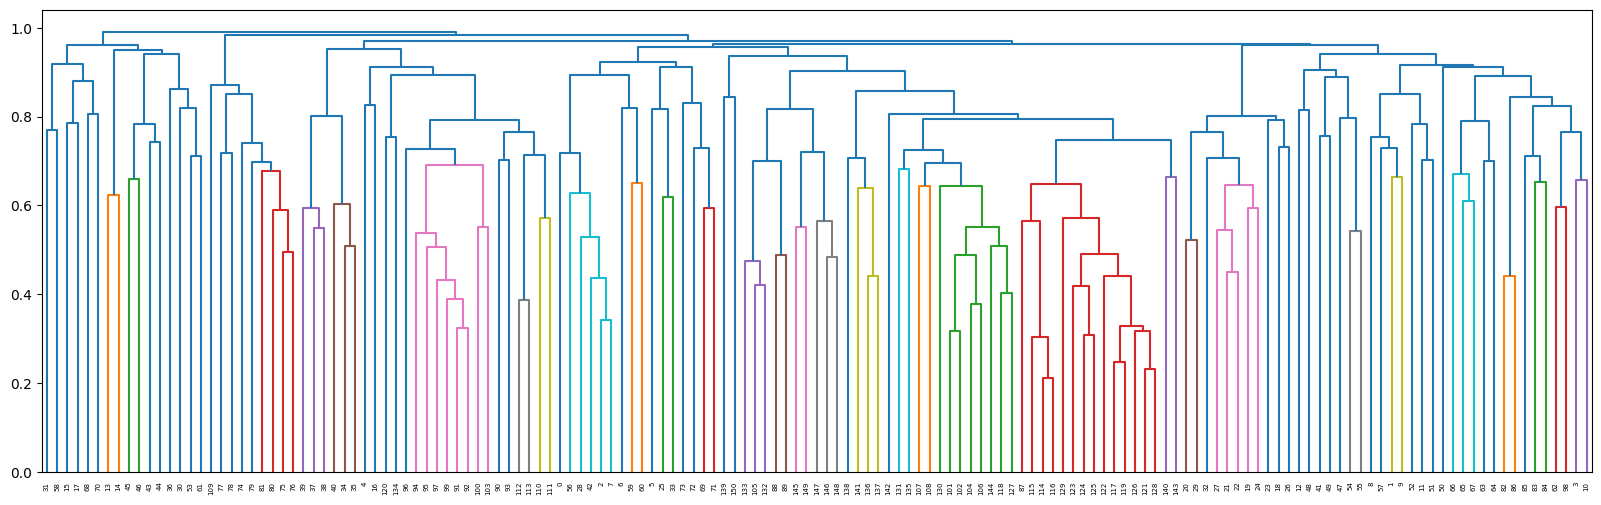

In [42]:
plt.figure(figsize=(20,6))
tfidf = TfidfVectorizer()
text_tfidf_c = tfidf.fit_transform(df_comb['text'])
feature_names_c = tfidf.get_feature_names_out()
print(len(feature_names_c), feature_names_c)
tree_c = hac.linkage(text_tfidf_c.toarray(), method="complete",metric="cosine") #equivalent to 'euclidean'
plt.clf()
hac.dendrogram(tree_c)#,labels=df_dora['text'])#, labels=df_dora['title']) #, labels=dora_text
plt.show() 

In [43]:
if 'en_core_web_sm' not in spacy.util.get_installed_models():
    !python -m spacy download en_core_web_sm
else:
    print('en_core_web_sm is already installed')

en_core_web_sm is already installed


In [44]:

def spacy_pipeline(df, spacy_model):
    nlp = spacy_model

    documents = list(nlp.pipe(texts=df['text']))
    df['tokens'] = [[token for token in doc ] for doc in documents]
    df['filtered_tokens'] = [[token for token in doc if not token.is_stop] for doc in documents]
    df['pos'] = [[token.tag_ for token in doc ] for doc in documents]
    df['lemmas'] = [[token.lemma_ for token in doc ] for doc in documents]
    df['ents'] = [[ent for ent in doc.ents ] for doc in documents]
    df['ents_type'] = [[ent.label_ for ent in doc.ents ] for doc in documents]
    return df
en_model = spacy.load('en_core_web_sm')
df_dora_nlp = spacy_pipeline(df_dora, en_model)
df_dora_nlp

,text,title,tokens,filtered_tokens,pos,lemmas,ents,ents_type
0,Article 1\nSubject matter\n1. In order to achi...,Article 1,"[Article, 1, \n, Subject, matter, \n, 1, ., In...","[Article, 1, \n, Subject, matter, \n, 1, ., or...","[NN, CD, _SP, NN, NN, _SP, CD, ., IN, NN, TO, ...","[article, 1, \n, subject, matter, \n, 1, ., in...","[(Article, 1, \n, Subject), (1), (Regulation),...","[LAW, CARDINAL, ORG, ORG, ORG, PERSON, LAW, PE..."
1,Article 2\nScope\n1. Without prejudice to para...,Article 2,"[Article, 2, \n, Scope, \n, 1, ., Without, pre...","[Article, 2, \n, Scope, \n, 1, ., prejudice, p...","[NN, CD, _SP, NN, _SP, CD, ., IN, NN, IN, NNS,...","[article, 2, \n, scope, \n, 1, ., without, pre...","[(Article, 2, \n, Scope), (1), (3), (Directive...","[LAW, CARDINAL, CARDINAL, PERSON, ORG, DATE, C..."
2,Article 3\nDef initions\nFor the purposes of t...,Article 3,"[Article, 3, \n, Def, initions, \n, For, the, ...","[Article, 3, \n, Def, initions, \n, purposes, ...","[NN, CD, _SP, NNP, NNS, _SP, IN, DT, NNS, IN, ...","[article, 3, \n, Def, inition, \n, for, the, p...","[(Article, 3, \n, Def), (ICT), (third), (ICT),...","[LAW, ORG, ORDINAL, ORG, CARDINAL, LAW, PERSON..."
3,Article 4\nPropor tionality principle\n1. Fina...,Article 4,"[Article, 4, \n, Propor, tionality, principle,...","[Article, 4, \n, Propor, tionality, principle,...","[NN, CD, _SP, JJ, NN, NN, _SP, CD, ., JJ, NNS,...","[article, 4, \n, propor, tionality, principle,...","[(Article, 4), (1), (Chapt), (II), (2), (Chapt...","[LAW, CARDINAL, GPE, CARDINAL, CARDINAL, GPE, ..."
4,Article 5\nGovernance and organisation\n1. Fin...,Article 5,"[Article, 5, \n, Governance, and, organisation...","[Article, 5, \n, Governance, organisation, \n,...","[NN, CD, _SP, NNP, CC, NN, _SP, CD, ., JJ, NNS...","[article, 5, \n, Governance, and, organisation...","[(Article, 5, \n, Governance), (1), (ICT), (Ar...","[LAW, CARDINAL, ORG, LAW, PERSON, CARDINAL, GP..."
...,...,...,...,...,...,...,...,...
59,Article 60\nAmendments to Regulation (EU) No 6...,Article 60,"[Article, 60, \n, Amendments, to, Regulation, ...","[Article, 60, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 60, \n, amendment, to, Regulation, (...","[(Article, 60, \n, Amendments, to, Regulation)...","[LAW, ORG, ORG, LAW, CARDINAL, CARDINAL, ORG, ..."
60,Article 61\nAmendments to Regulation (EU) No 9...,Article 61,"[Article, 61, \n, Amendments, to, Regulation, ...","[Article, 61, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 61, \n, amendment, to, Regulation, (...","[(Article, 61, \n, Amendments, to, Regulation)...","[LAW, ORG, LAW, ORG, CARDINAL, CARDINAL, ORG, ..."
61,Article 62\nAmendments to Regulation (EU) No 6...,Article 62,"[Article, 62, \n, Amendments, to, Regulation, ...","[Article, 62, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 62, \n, amendment, to, Regulation, (...","[(Article, 62, \n, Amendments, to, Regulation)...","[LAW, ORG, ORG, LAW, CARDINAL, ORG, GPE, ORG, ..."
62,Article 63\nAmendment to Regulation (EU) 2016/...,Article 63,"[Article, 63, \n, Amendment, to, Regulation, (...","[Article, 63, \n, Amendment, Regulation, (, EU...","[NN, CD, _SP, NNP, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 63, \n, Amendment, to, Regulation, (...","[(Article, 63, \n, Amendment, to, Regulation),...","[LAW, ORG, CARDINAL, LAW, ORG, DATE, CARDINAL,..."


In [45]:
df_bait_nlp = spacy_pipeline(df_bait, en_model)
df_bait_nlp

,text,title,tokens,filtered_tokens,pos,lemmas,ents,ents_type
0,1.1. The IT strategy shall fulfil the requirem...,1.1.,"[1.1, ., The, IT, strategy, shall, fulfil, the...","[1.1, ., strategy, shall, fulfil, requirements...","[CD, ., DT, NNP, NN, MD, VB, DT, NNS, VBN, RP,...","[1.1, ., the, IT, strategy, shall, fulfil, the...","[(1.1), (AT), (4.2), (MaRisk)]","[CARDINAL, GPE, CARDINAL, GPE]"
1,1.2. The management board shall define an IT s...,1.2.,"[1.2, ., The, management, board, shall, define...","[1.2, ., management, board, shall, define, str...","[CD, ., DT, NN, NN, MD, VB, DT, NNP, NN, WDT, ...","[1.2, ., the, management, board, shall, define...","[(1.2), (third), (third)]","[CARDINAL, ORDINAL, ORDINAL]"
2,2.1. IT governance is the structure used to ma...,2.1.,"[2.1, ., IT, governance, is, the, structure, u...","[2.1, ., governance, structure, manage, monito...","[CD, ., NNP, NN, VBZ, DT, NN, VBN, TO, VB, CC,...","[2.1, ., IT, governance, be, the, structure, u...","[(2.1), (AT, 4.3.1), (MaRisk), (4.3.2), (MaRis...","[CARDINAL, CARDINAL, PERSON, CARDINAL, GPE, CA..."
3,2.2. The management board is responsible for e...,2.2.,"[2.2, ., The, management, board, is, responsib...","[2.2, ., management, board, responsible, ensur...","[CD, ., DT, NN, NN, VBZ, JJ, IN, VBG, IN, DT, ...","[2.2, ., the, management, board, be, responsib...",[(2.2)],[CARDINAL]
4,2.3. The institution shall ensure that appropr...,2.3.,"[2.3, ., The, institution, shall, ensure, that...","[2.3, ., institution, shall, ensure, appropria...","[CD, ., DT, NN, MD, VB, IN, JJ, NNS, ,, IN, NN...","[2.3, ., the, institution, shall, ensure, that...",[(2.3)],[CARDINAL]
...,...,...,...,...,...,...,...,...
82,12.1. Against the backdrop of the other chapte...,12.1.,"[12.1, ., Against, the, backdrop, of, the, oth...","[12.1, ., backdrop, chapters, BAIT, relevant, ...","[CD, ., IN, DT, NN, IN, DT, JJ, NNS, IN, DT, N...","[12.1, ., against, the, backdrop, of, the, oth...","[(12.1), (CI, operators1), (Supervisory, Requi...","[CARDINAL, ORG, WORK_OF_ART, LAW, ORG, PERSON,..."
83,12.2. The extent of critical infrastructure w...,12.2.,"[12.2, ., , The, extent, of, critical, infras...","[12.2, ., , extent, critical, infrastructure,...","[CD, ., _SP, DT, NN, IN, JJ, NN, IN, DT, NN, N...","[12.2, ., , the, extent, of, critical, infras...","[(12.2), (3.3), (CI), (Appropriate)]","[CARDINAL, CARDINAL, ORG, ORG]"
84,12.3. The information risk management and info...,12.3.,"[12.3, ., The, information, risk, management, ...","[12.3, ., information, risk, management, infor...","[CD, ., DT, NN, NN, NN, CC, NN, NN, NN, _SP, N...","[12.3, ., the, information, risk, management, ...","[(12.3), (3), (CIP)]","[CARDINAL, CARDINAL, ORG]"
85,12.4. The CIP objective shall always be taken...,12.4.,"[12.4, ., , The, CIP, objective, shall, alway...","[12.4, ., , CIP, objective, shall, taken, acc...","[CD, ., _SP, DT, NNP, NN, MD, RB, VB, VBN, IN,...","[12.4, ., , the, CIP, objective, shall, alway...","[(12.4), (25a), (25b), (German), (ActCritical)...","[CARDINAL, DATE, CARDINAL, NORP, ORG, NORP, CA..."


In [46]:
df_comb_nlp = spacy_pipeline(df_comb, en_model)
df_comb_nlp

,origin,text,title,tokens,filtered_tokens,pos,lemmas,ents,ents_type
0,bait,1.1. The IT strategy shall fulfil the requirem...,1.1.,"[1.1, ., The, IT, strategy, shall, fulfil, the...","[1.1, ., strategy, shall, fulfil, requirements...","[CD, ., DT, NNP, NN, MD, VB, DT, NNS, VBN, RP,...","[1.1, ., the, IT, strategy, shall, fulfil, the...","[(1.1), (AT), (4.2), (MaRisk)]","[CARDINAL, GPE, CARDINAL, GPE]"
1,bait,1.2. The management board shall define an IT s...,1.2.,"[1.2, ., The, management, board, shall, define...","[1.2, ., management, board, shall, define, str...","[CD, ., DT, NN, NN, MD, VB, DT, NNP, NN, WDT, ...","[1.2, ., the, management, board, shall, define...","[(1.2), (third), (third)]","[CARDINAL, ORDINAL, ORDINAL]"
2,bait,2.1. IT governance is the structure used to ma...,2.1.,"[2.1, ., IT, governance, is, the, structure, u...","[2.1, ., governance, structure, manage, monito...","[CD, ., NNP, NN, VBZ, DT, NN, VBN, TO, VB, CC,...","[2.1, ., IT, governance, be, the, structure, u...","[(2.1), (AT, 4.3.1), (MaRisk), (4.3.2), (MaRis...","[CARDINAL, CARDINAL, PERSON, CARDINAL, GPE, CA..."
3,bait,2.2. The management board is responsible for e...,2.2.,"[2.2, ., The, management, board, is, responsib...","[2.2, ., management, board, responsible, ensur...","[CD, ., DT, NN, NN, VBZ, JJ, IN, VBG, IN, DT, ...","[2.2, ., the, management, board, be, responsib...",[(2.2)],[CARDINAL]
4,bait,2.3. The institution shall ensure that appropr...,2.3.,"[2.3, ., The, institution, shall, ensure, that...","[2.3, ., institution, shall, ensure, appropria...","[CD, ., DT, NN, MD, VB, IN, JJ, NNS, ,, IN, NN...","[2.3, ., the, institution, shall, ensure, that...",[(2.3)],[CARDINAL]
...,...,...,...,...,...,...,...,...,...
146,dora,Article 60\nAmendments to Regulation (EU) No 6...,Article 60,"[Article, 60, \n, Amendments, to, Regulation, ...","[Article, 60, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 60, \n, amendment, to, Regulation, (...","[(Article, 60, \n, Amendments, to, Regulation)...","[LAW, ORG, ORG, LAW, CARDINAL, CARDINAL, ORG, ..."
147,dora,Article 61\nAmendments to Regulation (EU) No 9...,Article 61,"[Article, 61, \n, Amendments, to, Regulation, ...","[Article, 61, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 61, \n, amendment, to, Regulation, (...","[(Article, 61, \n, Amendments, to, Regulation)...","[LAW, ORG, LAW, ORG, CARDINAL, CARDINAL, ORG, ..."
148,dora,Article 62\nAmendments to Regulation (EU) No 6...,Article 62,"[Article, 62, \n, Amendments, to, Regulation, ...","[Article, 62, \n, Amendments, Regulation, (, E...","[NN, CD, _SP, NNS, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 62, \n, amendment, to, Regulation, (...","[(Article, 62, \n, Amendments, to, Regulation)...","[LAW, ORG, ORG, LAW, CARDINAL, ORG, GPE, ORG, ..."
149,dora,Article 63\nAmendment to Regulation (EU) 2016/...,Article 63,"[Article, 63, \n, Amendment, to, Regulation, (...","[Article, 63, \n, Amendment, Regulation, (, EU...","[NN, CD, _SP, NNP, IN, NNP, -LRB-, NNP, -RRB-,...","[article, 63, \n, Amendment, to, Regulation, (...","[(Article, 63, \n, Amendment, to, Regulation),...","[LAW, ORG, CARDINAL, LAW, ORG, DATE, CARDINAL,..."


In [47]:
str(df_comb_nlp['ents'][0][0])

'1.1'

## Basic analysis of dora and bait data

counting tokens for each pdf

In [15]:
sum(len(x) for x in df_bait['tokens'])

10722

In [16]:
sum(len(x) for x in df_dora['tokens'])

39974

most important words based on tfidf

In [14]:

feature_names_d = tfidf.get_feature_names_out()
word_scores_d = text_tfidf.toarray().flatten()

# Combine words with their scores
word_score_dict_d = dict(zip(feature_names_d, word_scores_d))

# Sort words by score
sorted_word_scores_d = sorted(word_score_dict_d.items(), key=lambda x: x[1], reverse=True)

# Print the top N words with highest TF-IDF scores
top_n = 10
for word, score in sorted_word_scores_d[:top_n]:
    print(f"{word}: {score}")

investor: 0.27955726247918866
proportionality: 0.26402630345256706
pur: 0.2365763086867915
allowed: 0.23296438539932388
2017: 0.18990208270552233
nomic: 0.16178171491982807
organisation: 0.15750442168584614
delivering: 0.15363706252202275
subsidiar: 0.14617660353088036
networ: 0.14320797044463132


In [15]:
feature_names_b = tfidf_b.get_feature_names_out()
word_scores_b = text_tfidf_b.toarray().flatten()

# Combine words with their scores
word_score_dict_b = dict(zip(feature_names_b, word_scores_b))

# Sort words by score
sorted_word_scores_b = sorted(word_score_dict_b.items(), key=lambda x: x[1], reverse=True)

# Print the top N words with highest TF-IDF scores
top_n = 10
for word, score in sorted_word_scores_b[:top_n]:
    print(f"{word}: {score}")

strategy: 0.35015339911026266
objectives: 0.3287317156317985
the: 0.3239113513770026
outlining: 0.25535715566918993
sustainable: 0.25535715566918993
achieve: 0.2337153678948196
fulfil: 0.2064499398267039
to: 0.20378297686972646
out: 0.1884906614786852
set: 0.18136339453855405


Wordclouds

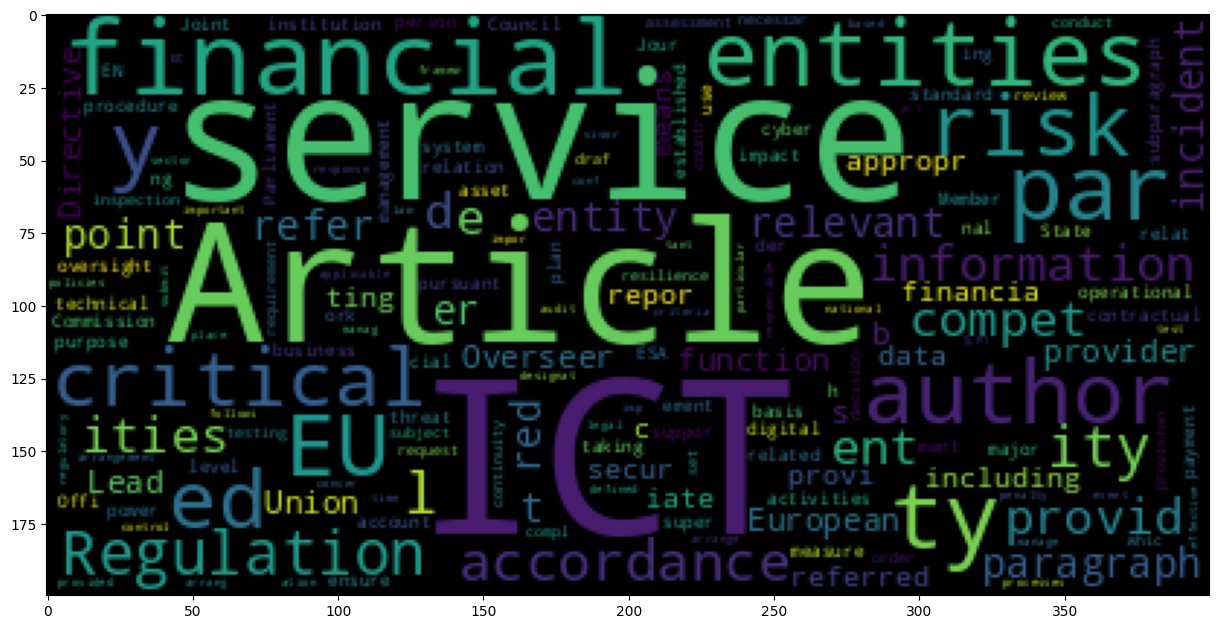

In [18]:
wc_d_raw = df_dora_nlp['filtered_tokens'].sum()
wc_d_input = ' '.join(map(lambda l: str(l), wc_d_raw))
wc_d = wordcloud.WordCloud(collocations=False).generate(wc_d_input)
plt.figure(figsize=(15,10))
plt.clf
plt.imshow(wc_d)
plt.show()

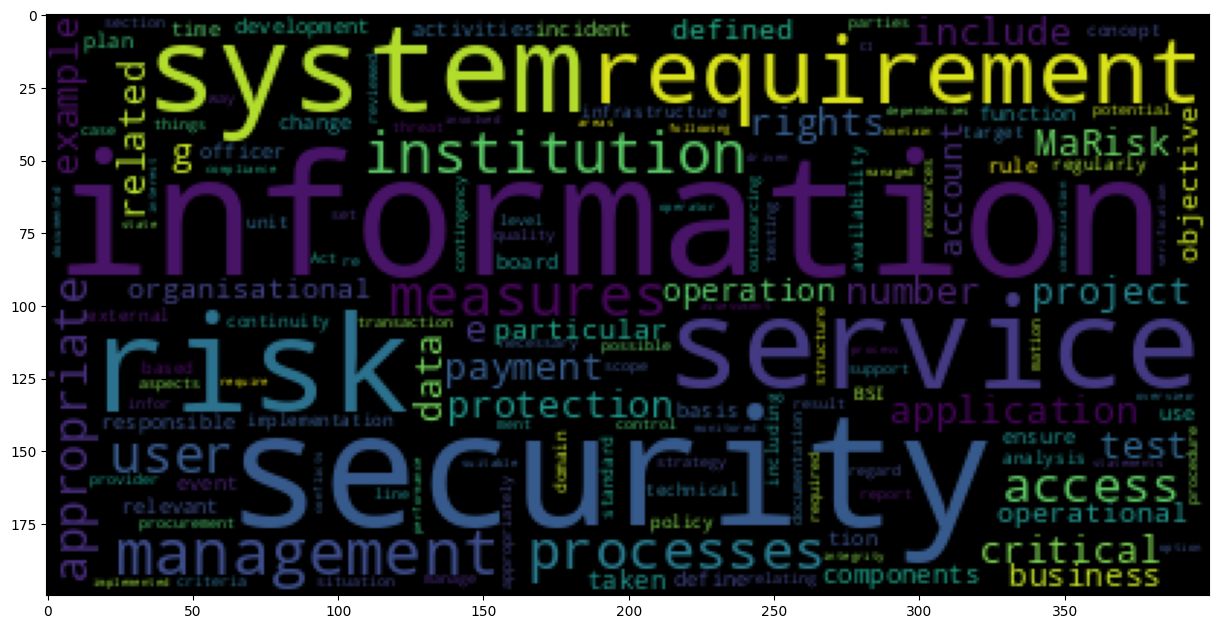

In [19]:
wc_b_raw = df_bait_nlp['filtered_tokens'].sum()
wc_b_input = ' '.join(map(lambda l: str(l), wc_b_raw))
wc_b = wordcloud.WordCloud(collocations=False).generate(wc_b_input)
plt.figure(figsize=(15,10))
plt.clf
plt.imshow(wc_b)
plt.show()

In [8]:
print(df_bait['text'][7])

3.1. The processing and sharing of information in business and service processes is supported by data processing IT systems and related IT processes.
The scope and quality thereof shall be based, in particular, on the institution’s internal operating needs, business activities and risk situation (see AT
7.2 number 1 of MaRisk). The IT systems, the related IT processes and the other components of the information domain shall ensure the integrity,
availability, authenticity and confidentiality of the data (see AT 7.2 number 2 of MaRisk). The institution shall define and coordinate the tasks, com-
petencies, responsibilities, controls and reporting channels required for the management of information risk (see AT 4.3.1 number 2 of MaRisk). To
this end, the institution shall set up appropriate monitoring and steering processes (see AT 7.2 number 4 of MaRisk) and define the related report-
ing requirements (see BT 3.2 number 1 of MaRisk).



In [26]:
round(len(df_comb_nlp['text'][84])/512)

3